# Text Classification

    - 감정 감지기를 개발하기 위해 영어로 작성된 트위터 메시지에 감정이 어떻게 표현되는지 연구한 논문의 데이터셋 이용

In [2]:
from datasets import list_datasets

all_datasets = list_datasets()

print(f" 현재 허브에 있는 데이터셋 -> {len(all_datasets)} 개")
print(f" 상단의 10개 데이터 셋 -> {all_datasets[:10]}")

 현재 허브에 있는 데이터셋 -> 10000 개
 상단의 10개 데이터 셋 -> ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [3]:
from datasets import load_dataset

emotions = load_dataset('emotion')
emotions

No config specified, defaulting to: emotion/split
Found cached dataset emotion (C:/Users/PC/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [6]:
len(train_ds)

16000

In [7]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [10]:
train_ds.column_names

['text', 'label']

    - 해당 데이터는 아파치 애로우(Apach Arrow) 기반으로 하며,
    파이썬보다 훨씬 메모리 측면에서 효율적인 열기반 포맷(columnar format) 사용

In [11]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [12]:
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

In [13]:
train_ds['text'][:5]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy']

    - 데이터셋 다운로드

In [16]:
dataset_url = 'https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt'
!wget {dataset_url}

--2023-04-12 14:19:38--  https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.84.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.84.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/1pzkadrvffbqw6o/train.txt [following]
--2023-04-12 14:19:38--  https://www.dropbox.com/s/raw/1pzkadrvffbqw6o/train.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 404 Not Found
2023-04-12 14:19:39 ERROR 404: Not Found.



In [17]:
!head -n 1 train.txt

head: cannot open 'train.txt' for reading: No such file or directory


In [18]:
import pandas as pd


In [19]:
emotions.set_format(type='pandas')
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [21]:
def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)

df['label_name'] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


    - 텍스트 분류 모델을 다루기 위해서, 샘플의 클래스 분포 조사
    - 클래스 분포가 편향된 데이터셋은 훈련 손실과 평가 지표 측면에서 균현 잡힌 데이터셋과 다른 처리가 필요하므로

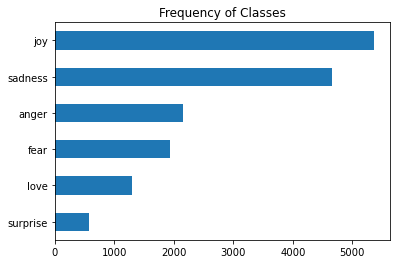

In [22]:
import matplotlib.pyplot as plt

df['label_name'].value_counts(ascending=True).plot.barh()
plt.title('Frequency of Classes')
plt.show()

    - joy와 sadness 클래스가 많고, lov와 suprise 클래스는 5~10배 작은 imbalnace한 data
    
       * 소수 클래스를 over sampling 하거나
       * 다수 클래스를 under sampling 하거나
       * 클래스의 대표성이 부족하면 레이블된 데이터를 더 수집함
      
      
     **중요한 건, train/test 분할하기 전, sampling 전략 수행하지 말 것**

    - 트랜스포머 모델은 최대 문맥 크기(maximum contextg size) 라는 최대 입력 시퀀스 길이가 있음
    - DistilBERT를 사용하는 애플리케이션은 최대 문맥 크기가 512 토큰으로 문단 몇개 정도임
    - 토큰 : 텍스트의 기본 단위

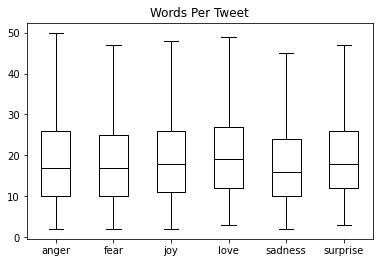

In [23]:
df['Words Per Tweet'] = df['text'].str.split().apply(len)
df.boxplot('Words Per Tweet', by='label_name', grid=False,
           showfliers=False, color='black')

plt.suptitle('')
plt.xlabel('')
plt.show()

    - 각 감정의 트윗 길이는 15개 단어 정도
    - 가장 긴 트윗도 DistillBERT의 최대 문맥 크기보다 작음
    - 텍스트가 모델의 문맥 크기보다 길면 잘라내야 하는데, 잘린 텍스트에 중요한 정보가 있을 경우 성능에 손실이 생길 수 있음

In [24]:
emotions.reset_format()

    - DistilBERT 같은 트랜스포머 모델은 원시 문자열을 input으로 받을 수 없어서,
    텍스트를 토큰화 하여 수치 벡터로 인코딩하여 사용함
    - 토큰화는 문자열을 모델이 사용하는 기본 단위로 분할함
    - 적용할 수 있는 토큰화 전략이 있으며, 단어를 부분단위로 나누기 위한 최적 분할은 말뭉치에서 학습됨
    - 문자 토큰화와 단어 토큰화 등의 방식이 있음

In [26]:
# 문자 토큰화

text = 'Tokenizing textg is a core task of NLP.'
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', 'g', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [27]:
# 수치화(numericalzation)

token2idx = {ch:idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [32]:
# 어휘사전 (vocabulary)에 있는 각 문자를 고유한 정수로 바꿈

input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 10, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [33]:
#input_ids를 원-핫 벡터(one-hot vector)의 2d Tensor로 변환

In [34]:
categorical_df = pd.DataFrame(
{'Name' : ['Bumblebee', 'Optimus Prime', 'Megatron'],
'Label ID ': [0,1,2]})

categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


In [35]:
pd.get_dummies(categorical_df['Name'])

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


In [38]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes = len(token2idx))
one_hot_encodings

C:\Users\PC\AppData\Local\Temp\ipykernel_2040\2475823840.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids)


tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0,

In [39]:
one_hot_encodings.shape

torch.Size([39, 20])

    - 38개의 입력 토큰에 각 20차원의 원-핫 벡터가 만들어짐
       (어휘사전을 구성하는 고유한 문자가 20개)

In [40]:
print(f"토큰 -> {tokenized_text[0]}")
print(f"텐서 인덱스 -> {input_idx[0]}")
print(f"원-핫 인코딩 : {one_hot_encodings[0]}")

토큰 -> T
텐서 인덱스 -> 5
원-핫 인코딩 : tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


    - 문자 수준의 토큰화는 텍스트 구조를 무시하고, 전체 문자열은 문자 스트림으로 처리함
    : 철자오류, 희귀한 단어 처리시 유용하지만 단어 같은 언어 구조를 이 데이터에서 학습해야하는 단점이 있어,
    상당한 계산과 메모리, 데이터가 필요하므로 문자 수준의 토큰화는 거의 사용하지 않고, 텍스트 일부 구조가 유지되는 '단어 토큰화'를 사용

In [41]:
# 단어 토큰화(word tokenization)

tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'textg', 'is', 'a', 'core', 'task', 'of', 'NLP.']


    -> 구두점이 처리되지 않아서 NLP. 가 하나의 토큰으로 처리됨
    단어의 곡용(declination), 활용, 철자 오류가 포함되서 어휘사전이 매우 커짐
    
    - 일부 단어 토크나이저에서는 구두점을 추가하는 규칙이 있는데,
    텍스트에서 일부 정보를 잃는 대신 단어를 어간(stem)으로 정규화하는 어간 추출(stemming)이나 표제어 추출 (lemmatization)을 적용함

### 부분단어 토큰화(subword tokenization)

    - BPE, SentencePiece, WordPiece

In [43]:
from transformers import AutoTokenizer

model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [44]:
from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [45]:
encoded_text = tokenizer('Tokenizing text is a core task of NLP.')
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [93]:
encoded_text = distilbert_tokenizer('Tokenizing text is a core task of NLP.')
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [47]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


    - [CLS], [SEP] : 특수한 토큰으로 시작과 끝
    - '토큰이 모두 소문자
    - 'tokenizing', 'NLP' 각각 두 개의 토큰 -> 자주 등장하는 단어가 아니여서 
    - ##izing , ##p 는 앞의 문자열이 공백이 아님을 뜻함 -> 이러한 접두사가 붙은 토큰은 문자열로 다시 바꿀 때 앞의 토큰과 합쳐짐

In [48]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [49]:
tokenizer.vocab_size

30522

In [50]:
tokenizer.model_max_length

512

In [51]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [98]:
def distil_tokenize(batch):
    return distilbert_tokenizer(batch['text'], padding=True, truncation=True)

In [96]:
print(distilbert_tokenizer(emotions['train'][:2]['text'], padding=True, truncation=True))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [99]:
emotions_encoded = emotions.map(distil_tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

    - bath_size = None : 전체 데이터셋이 하나의 배치로 tokenize() 함수에 사용
     : 입력 텐서와 어텐션 마스크가 전역적으로 동일한 크기로 생성 됨

In [101]:
print(emotions_encoded['train'].column_names)

['text', 'label', 'input_ids', 'attention_mask']


In [107]:
print(emotions_encoded['train'][:1])

{'text': ['i didnt feel humiliated'], 'label': [0], 'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


In [109]:
# 사전 훈련된 모델 사용

from transformers import AutoModel

model_ckpt = 'distilbert-base-uncased'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModel.from_pretrained(model_ckpt).to(device)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [110]:
# 텐서플로 에서 DistilBERT 로드

from transformers import TFAutoModel

tf_model = TFAutoModel.from_pretrained(model_ckpt)
tf_xlmr = TFAutoModel.from_pretrained('xlm-roberta-base')

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFXLMRobertaModel.

All the layers of TFXLMRobertaModel were initialized from the model checkpoint at xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [111]:
tf_xlmr = TFAutoModel.from_pretrained('xlm-roberta-base', from_pt=True)

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [115]:

# 마지막 은닉 상태 추출

text = 'this is a test'
inputs = distilbert_tokenizer(text, return_tensors='pt')
print(f" 입력 텐서 크기 -> {inputs['input_ids'].size()}")

 입력 텐서 크기 -> torch.Size([1, 6])


    - 텐서의 크기는 [batch_zize, n_tokens] 

In [116]:
inputs = {k:v.to(device) for k,v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)


     - torch.no_grad() : 컨텍스트 매니저 (계싼에 필요한 메모리 야이 줄어 추론시 유리함)

In [117]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

    -> 은닉 상태 텐서의 크기 [batch_size, n_tokens, hidden_dim]
    6개의 입력 토큰마다 768차원의 벡터 반환
    - 분류 작업에서는 보통 [CLS] 토큰에 연관된 은닉 상태를 입력 특성으로 사용함

In [118]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [130]:
def extract_hidden_states(batch):
    # 모델 입력 GPU로 옮김
    inputs = {k:v.to(device) for k,v in batch.items() if k in distilbert_tokenizer.model_input_names}
    
    #마지막 은닉 상태 추출
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
        
    # [CLS] 토큰에 대한 벡터 반환
    return {'hidden_state' : last_hidden_state[:, 0].cpu().numpy()}

In [125]:
emotions_encoded.set_format('torch', columns=['input_ids','attention_mask', 'label'])

In [131]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)
emotions_hidden

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
})

In [132]:
emotions_hidden['train'].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [134]:
#특성 행렬 만듦

import numpy as np

X_train = np.array(emotions_hidden['train']['hidden_state'])
X_valid = np.array(emotions_hidden['validation']['hidden_state'])
y_train = np.array(emotions_hidden['train']['label'])
y_valid = np.array(emotions_hidden['validation']['label'])

X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

    <훈련 세트 시각화>
    
    - 768차원의 은닉 상태를 시각화하기 어려워 UMAP 알고리즘을 사용해 벡터를 2D로 투영
    - UMAP은 특성이 [0,1] 범위에 놓일 때 잘 동작하여, 사이킷런의 MinMaxScaler를 적용해 umap-learn 라이브러리 UMAP 구현

In [138]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# 특성 스케일을 [0,1] 범위로 조정
X_scaled = MinMaxScaler().fit_transform(X_train)
# UAMP 객체 생성 및 훈련
mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)

# 2D 임베딩 데이터프레임
df_emb = pd.DataFrame(mapper.embedding_, columns=['X','Y'])
df_emb['label'] = y_train
df_emb.head()

,X,Y,label
0,4.755807,5.902638,0
1,-2.615590,5.470538,0
2,5.282946,2.290473,3
3,-1.904680,2.903856,2
4,-3.024427,3.342697,3


In [139]:
print(mapper)

UMAP(angular_rp_forest=True, metric='cosine', tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})


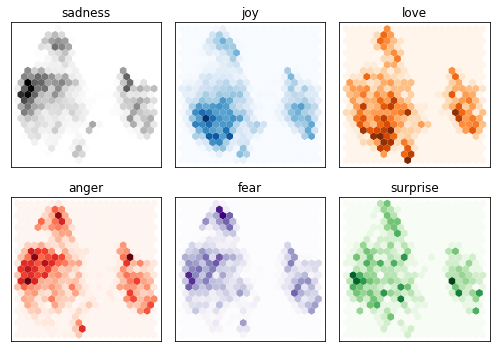

In [142]:
# 각 범주에 대한 샘플 밀도 

fig, axes = plt.subplots(2,3, figsize=(7,5))
axes = axes.flatten()
cmaps = ['Greys', 'Blues', 'Oranges', 'Reds', 'Purples' ,'Greens']
labels = emotions['train'].features['label'].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label=={i}")
    axes[i].hexbin(df_emb_sub['X'], df_emb_sub['Y'], cmap=cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
    
plt.tight_layout()
plt.show()

    - 위 그림은 저차원 공간으로 투영 된 것으로, 일부 범주가 중첩됐기 때문에 원본 공간에서 분리할 수 없는 것이 아님
    투영 공간에서 분리할 수 있으면, 원본 공간에서도 분리 가능
    
    - sadness, anger, fear 같은 부정적 감정은 조금씩 다르게 분포
    - joy와 lov는 부정적 감정과 잘 분리되고 비슷한 영역 차지 
    - surprise는 영역 전체에 고루 퍼져있음

In [145]:
# 간단한 분류 모델 학습 
# 은ㄴ기 상태가 감정별로 조금 다르지만, 일부 감정에 명확한 경계가 없어 은닉 상태를 이용해 로지스틱 회귀 훈련

from sklearn.linear_model import LogisticRegression

# 수렴 보장을 위해 max_iter 증가
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

    -> 정확도는 모델이 무작위로 예측한 것보다는 좋음
    - 사이킬럿의 DummyClassifier로 간단한 규칙을 사용하는 분류 모델을 만들어서 비교해 봄

In [146]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy = 'most_frequent')
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

    - DistillBERT 임베딩을 사용한 간단한 모델은 기본 모델보다 뛰어남
    분류 모델의 성능 예측을 위해 오차 행렬(confusion matrix) 로 확인

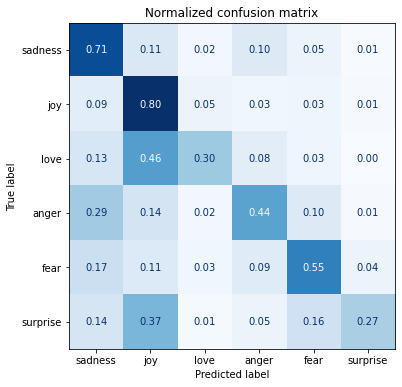

In [148]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize='true')
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title('Normalized confusion matrix')
    plt.show()
    
y_preds= lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

    - anger와 fear는 sadness와 가장 많이 혼동 됨
    - love와 surprise는 joy로 많이 오인함

### 미세 튜닝 (fine-tuning)


    - AutoModel 클래스 대신 AutoModelForSequenceClassification 사용
    : 사전 훈련된 모델 출력을 위해 베이스 모델(base model)과 함께 훈련할 수 있는 분류 헤드가 있음

In [149]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

In [162]:
# 성공 지표 정의

from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1':f1}

In [154]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to C:\Users\PC\.huggingface\token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [159]:
from transformers import Trainer, TrainingArguments

batch_size= 64
logging_steps = len(emotions_encoded['train'])
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                 num_train_epochs=2,
                                 learning_rate=2e-5,
                                 per_device_train_batch_size=batch_size,
                                 per_device_eval_batch_size=batch_size,
                                 weight_decay=0.01,
                                 evaluation_strategy='epoch',
                                 disable_tqdm=False,
                                 logging_steps=logging_steps,
                                 push_to_hub=True,
                                 save_strategy='epoch',
                                 load_best_model_at_end=True,
                                 log_level='error')

In [163]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                 compute_metrics=compute_metrics,
                 train_dataset=emotions_encoded['train'],
                 eval_dataset=emotions_encoded['validation'],
                 tokenizer=distilbert_tokenizer)

trainer.train()

C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\huggingface_hub\repository.py:705: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.11.
  warnings.warn(
Cloning https://huggingface.co/kimgeonhee/distilbert-base-uncased-finetuned-emotion into local empty directory.
C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.307145,0.911500,0.909514
2,No log,0.215709,0.925000,0.924884


Several commits (2) will be pushed upstream.


TrainOutput(global_step=500, training_loss=0.5323363647460938, metrics={'train_runtime': 2946.6426, 'train_samples_per_second': 10.86, 'train_steps_per_second': 0.17, 'total_flos': 720342861696000.0, 'train_loss': 0.5323363647460938, 'epoch': 2.0})

    - 검증 set에서 f1 score 약 92%

In [164]:
# 오차행렬

preds_output = trainer.predict(emotions_encoded['validation'])

In [165]:
preds_output.metrics

{'test_loss': 0.21570852398872375,
 'test_accuracy': 0.925,
 'test_f1': 0.9248843709233031,
 'test_runtime': 43.6586,
 'test_samples_per_second': 45.81,
 'test_steps_per_second': 0.733}

In [167]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_preds

array([0, 0, 2, ..., 1, 1, 1], dtype=int64)

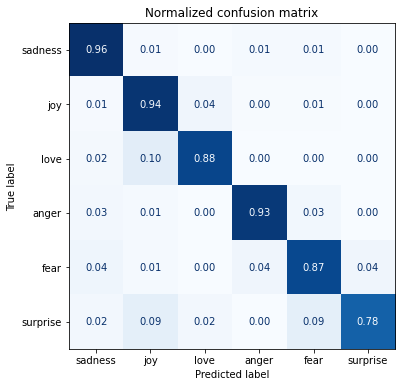

In [168]:
plot_confusion_matrix(y_preds, y_valid, labels)

    - 모델이 일으킬 가능성이 있는 오류 유형 보기
    
    <케라스로 미세 튜닝>
    
    - 텐서플로를 사용하면 케라스 Keras API로 모델을 미세튜닝 할 수 있음
    파이토치 API와 다른점은 케라스에는 Trainer 클래스가 없음
    케라스 모델에는 이미 fit() 메서드가 있음
    

In [171]:
from transformers import TFAutoModelForSequenceClassification

tf_model = (TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels))

In [172]:
# 데이터 셋을 tf.data.Dataset 포맷으로 변환

#텐스플로 텐서로 변환할 열
tokenizer_columns = DistilBertTokenizer.model_input_names

tf_train_dataset = emotions_encoded['train'].to_tf_dataset(columns=tokenizer_columns,
                                                          label_cols = ['label'], shuffle=True,
                                                          batch_size=batch_size)

tf_eval_dataset = emotions_encoded['validation'].to_tf_dataset(columns=tokenizer_columns,
                                                              label_cols=['label'], shuffle=False,
                                                              batch_size=batch_size)

In [174]:
import tensorflow as tf

tf_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=tf.metrics.SparseCategoricalAccuracy())

tf_model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=2)

Epoch 1/2
250/250 [==============================] - 1326s 5s/step - loss: 0.5347 - sparse_categorical_accuracy: 0.8083 - val_loss: 0.1744 - val_sparse_categorical_accuracy: 0.9310
Epoch 2/2
250/250 [==============================] - 1317s 5s/step - loss: 0.1525 - sparse_categorical_accuracy: 0.9359 - val_loss: 0.1384 - val_sparse_categorical_accuracy: 0.9385
